In [713]:
import pandas as pd
import numpy as np
from matplotlib import figure
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dr
import plotly
import pickle
import cufflinks as cf
from cufflinks.offline import go_offline
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [714]:
df = pd.read_excel("Data_Train.xlsx")

In [715]:
df.shape

(10683, 11)

In [716]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [717]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [718]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [719]:
df[df['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [720]:
df.dropna(inplace=True) #drop all null values.

In [721]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [722]:
data = df.copy()

In [723]:
data['Destination'].unique()
data['Destination'].replace('New Delhi','Delhi',inplace=True)

In [724]:
def change_into_datetime(col):
    data[col]=pd.to_datetime(data[col])
for feature in ['Date_of_Journey','Dep_Time', 'Arrival_Time']:
    change_into_datetime(feature)

In [725]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [726]:
data['journey_day']=data['Date_of_Journey'].dt.day
data['journey_month']=data['Date_of_Journey'].dt.month
data['journey_year']=data['Date_of_Journey'].dt.year


In [727]:
def extract_hour(df,col):
    df[col+'_hour']=df[col].dt.hour
    df[col+'_min']=df[col].dt.minute
    #df.drop(col,axis=1,inplace=True)
    return df.head(2)

In [728]:
extract_hour(data,'Dep_Time')
extract_hour(data,'Arrival_Time')

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,journey_year,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,2022-04-21 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-04-21 05:50:00,2022-04-21 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15


In [729]:
def flight_dep_time(x):
    if 4<x<=8:
        return 'Early Morning'
    elif 8<x<=12:
        return 'Morning'
    elif 12<x<=16:
        return 'Noon'
    elif 16<x<=20:
        return 'Evening'
    elif 20<x<=24:
        return 'Night'
    else:
        return 'Late Night'

<AxesSubplot:>

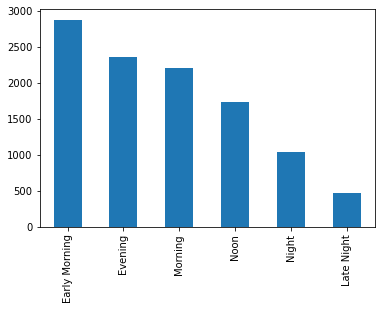

In [730]:
data['Dep_Time_hour'].apply(flight_dep_time).value_counts().plot(kind="bar") #Static Plot

In [731]:
data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,journey_year,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,2022-04-21 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-04-21 05:50:00,2022-04-21 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15


In [732]:
def hour(x):
    if 'h' not in x:
        x= '0h '+x
    if 'm' not in x:
        x= x + ' 0m'
    return x

In [733]:
data['Duration']=data['Duration'].apply(hour)

In [734]:
data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,journey_year,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,2022-04-21 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-04-21 05:50:00,2022-04-21 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-04-21 09:25:00,2022-06-10 04:25:00,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-04-21 18:05:00,2022-04-21 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,2019-01-03,Banglore,Delhi,BLR → NAG → DEL,2022-04-21 16:50:00,2022-04-21 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-09-04,Kolkata,Banglore,CCU → BLR,2022-04-21 19:55:00,2022-04-21 22:25:00,2h 30m,non-stop,No info,4107,4,9,2019,19,55,22,25
10679,Air India,2019-04-27,Kolkata,Banglore,CCU → BLR,2022-04-21 20:45:00,2022-04-21 23:20:00,2h 35m,non-stop,No info,4145,27,4,2019,20,45,23,20
10680,Jet Airways,2019-04-27,Banglore,Delhi,BLR → DEL,2022-04-21 08:20:00,2022-04-21 11:20:00,3h 0m,non-stop,No info,7229,27,4,2019,8,20,11,20
10681,Vistara,2019-01-03,Banglore,Delhi,BLR → DEL,2022-04-21 11:30:00,2022-04-21 14:10:00,2h 40m,non-stop,No info,12648,3,1,2019,11,30,14,10


In [735]:
data['Duration_hours']=data['Duration'].apply(lambda x: int(x.split(' ')[0][0:-1]))

In [736]:
data['Duration_mins']=data['Duration'].apply(lambda x: int(x.split(' ')[1][0:-1]))

In [737]:
data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,journey_year,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_hours,Duration_mins
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,2022-04-21 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-04-21 05:50:00,2022-04-21 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-04-21 09:25:00,2022-06-10 04:25:00,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-04-21 18:05:00,2022-04-21 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25
4,IndiGo,2019-01-03,Banglore,Delhi,BLR → NAG → DEL,2022-04-21 16:50:00,2022-04-21 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45


In [738]:
data['Duration_total_mins']=(data['Duration_hours'])*60 +data['Duration_mins']

In [739]:
data.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,journey_day,journey_month,journey_year,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_hours,Duration_mins,Duration_total_mins
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,2022-04-21 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,...,24,3,2019,22,20,1,10,2,50,170
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-04-21 05:50:00,2022-04-21 13:15:00,7h 25m,2 stops,No info,...,5,1,2019,5,50,13,15,7,25,445
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-04-21 09:25:00,2022-06-10 04:25:00,19h 0m,2 stops,No info,...,6,9,2019,9,25,4,25,19,0,1140


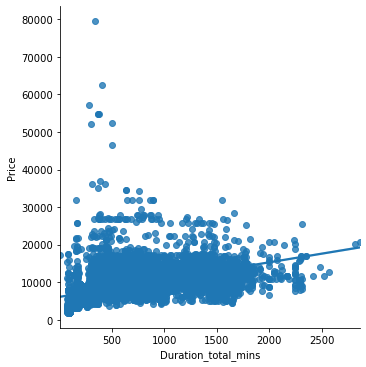

In [740]:
#Effect of Duration on Price
sns.lmplot(x='Duration_total_mins',y='Price',data=data)

<AxesSubplot:ylabel='Destination'>

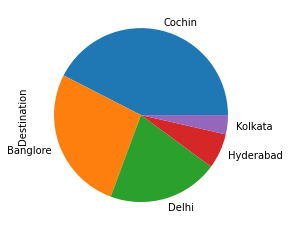

In [741]:
#Chart depicting distribution of destination
data['Destination'].value_counts().plot(kind='pie')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Vistara Premium economy'),
  Text(9, 0, 'Jet Airways Business'),
  Text(10, 0, 'Multiple carriers Premium economy'),
  Text(11, 0, 'Trujet')])

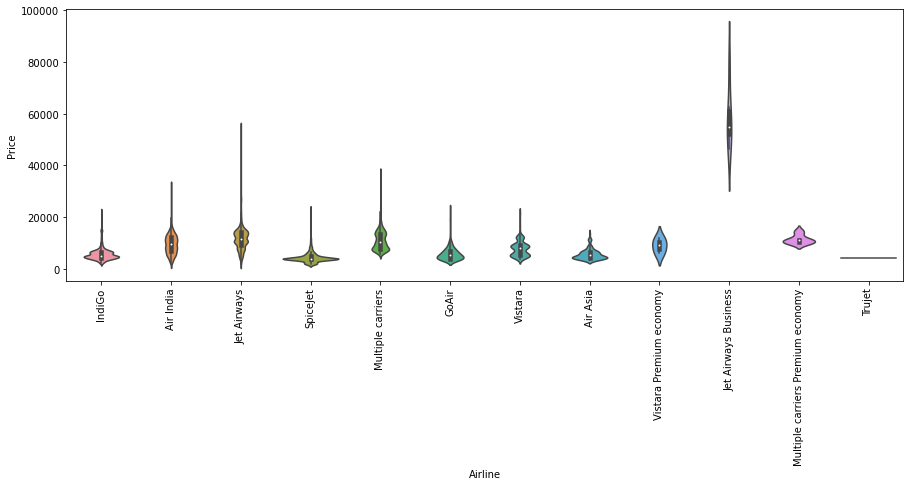

In [742]:
plt.figure( figsize =(15,5))
sns.violinplot(x='Airline',y='Price',data=data)
plt.xticks(rotation='vertical')

In [743]:
np.round((df['Additional_Info'].value_counts())/len(data)*100,2) #Calculating the percentage of info against full data

No info                         78.11
In-flight meal not included     18.55
No check-in baggage included     3.00
1 Long layover                   0.18
Change airports                  0.07
Business class                   0.04
No Info                          0.03
1 Short layover                  0.01
2 Long layover                   0.01
Red-eye flight                   0.01
Name: Additional_Info, dtype: float64

In [744]:
#columns:[Additional_Info','Route','journey_year'] has been removed from data as they are irrelevant to the ML model
data.drop('Date_of_Journey',inplace=True,axis=1)

In [745]:
data.drop('Route',inplace=True,axis=1)

In [746]:
data.drop('Additional_Info',inplace=True,axis=1)

In [747]:
cat_col=[col for col in data.columns if data[col].dtype == 'object'] # finding for all columns with dtype='object' 

In [748]:
#Ordinal Data: Label Encoder (High,Medium,Low)
#Normal Data: One hot encoder

In [749]:
for category in data['Source'].unique():
    data['Source_'+category]=data['Source'].apply(lambda x:1 if x==category else 0)

In [750]:
data.head(5)

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,journey_day,journey_month,...,Arrival_Time_hour,Arrival_Time_min,Duration_hours,Duration_mins,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,IndiGo,Banglore,Delhi,2022-04-21 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,3897,24,3,...,1,10,2,50,170,1,0,0,0,0
1,Air India,Kolkata,Banglore,2022-04-21 05:50:00,2022-04-21 13:15:00,7h 25m,2 stops,7662,5,1,...,13,15,7,25,445,0,1,0,0,0
2,Jet Airways,Delhi,Cochin,2022-04-21 09:25:00,2022-06-10 04:25:00,19h 0m,2 stops,13882,6,9,...,4,25,19,0,1140,0,0,1,0,0
3,IndiGo,Kolkata,Banglore,2022-04-21 18:05:00,2022-04-21 23:30:00,5h 25m,1 stop,6218,5,12,...,23,30,5,25,325,0,1,0,0,0
4,IndiGo,Banglore,Delhi,2022-04-21 16:50:00,2022-04-21 21:35:00,4h 45m,1 stop,13302,3,1,...,21,35,4,45,285,1,0,0,0,0


In [751]:
airlines = data.groupby(['Airline'])['Price'].mean().sort_values(ascending=True).index

dict_airline= {key:index for index,key in enumerate(airlines,start=0)} #Dictonary comprehension

stop={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}

In [752]:
dest= data.groupby(['Destination'])['Price'].mean().sort_values().index #To get the mean price when sorted destination wise

dict_dest={key:index for index,key in enumerate(dest,0)}

In [753]:
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [754]:
data['Airline']=data['Airline'].map(dict_airline)
data['Destination']=data['Destination'].map(dict_dest)
data['Total_Stops']=data['Total_Stops'].map(stop)

In [755]:
data.drop('Dep_Time',inplace=True,axis=1)
data.drop('Arrival_Time',inplace=True,axis=1)
data.drop('journey_year',inplace=True,axis=1)
data.drop('Duration',inplace=True,axis=1)
data.drop('Source',inplace=True,axis=1)

In [756]:
def plot(col,df):
    fig,(ax1,ax2,ax3)=plt.subplots(3,1)
    sns.boxplot(df[col],ax=ax1)
    sns.distplot(df[col],ax=ax2)
    sns.histplot(df[col],ax=ax3)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



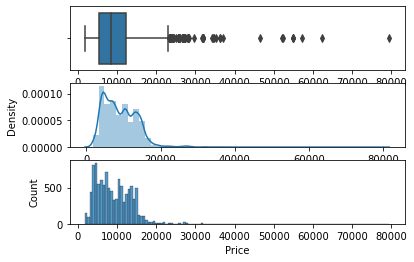

In [757]:
plot('Price',data)

In [758]:
data['Destination'].unique()

array([2, 3, 4, 0, 1], dtype=int64)

In [759]:
#To deal with outliers we replace all prices above 35000 with the median value of prices. 
data['Price']=np.where(data['Price']>35000,data['Price'].median(),data['Price'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



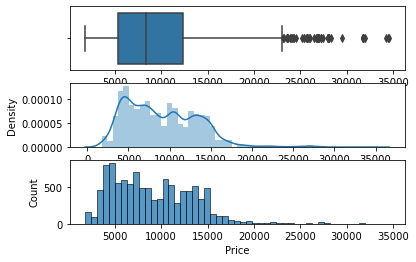

In [760]:
plot('Price',data)

In [761]:
data.dtypes

Airline                  int64
Destination              int64
Total_Stops              int64
Price                  float64
journey_day              int64
journey_month            int64
Dep_Time_hour            int64
Dep_Time_min             int64
Arrival_Time_hour        int64
Arrival_Time_min         int64
Duration_hours           int64
Duration_mins            int64
Duration_total_mins      int64
Source_Banglore          int64
Source_Kolkata           int64
Source_Delhi             int64
Source_Chennai           int64
Source_Mumbai            int64
dtype: object

In [762]:
#feature Selection

In [763]:
#filter Dependent variable(Price) and Independent variable(Others)
X=data.drop('Price',axis=1)

In [764]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Airline              10682 non-null  int64
 1   Destination          10682 non-null  int64
 2   Total_Stops          10682 non-null  int64
 3   journey_day          10682 non-null  int64
 4   journey_month        10682 non-null  int64
 5   Dep_Time_hour        10682 non-null  int64
 6   Dep_Time_min         10682 non-null  int64
 7   Arrival_Time_hour    10682 non-null  int64
 8   Arrival_Time_min     10682 non-null  int64
 9   Duration_hours       10682 non-null  int64
 10  Duration_mins        10682 non-null  int64
 11  Duration_total_mins  10682 non-null  int64
 12  Source_Banglore      10682 non-null  int64
 13  Source_Kolkata       10682 non-null  int64
 14  Source_Delhi         10682 non-null  int64
 15  Source_Chennai       10682 non-null  int64
 16  Source_Mumbai        1

In [765]:
y=data['Price']

In [766]:
y

0         3897.0
1         7662.0
2        13882.0
3         6218.0
4        13302.0
          ...   
10678     4107.0
10679     4145.0
10680     7229.0
10681    12648.0
10682    11753.0
Name: Price, Length: 10682, dtype: float64

In [767]:
#data.drop('Source',inplace=True,axis=1)
data.head(3)

,Airline,Destination,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_hours,Duration_mins,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2,0,3897.0,24,3,22,20,1,10,2,50,170,1,0,0,0,0
1,7,3,2,7662.0,5,1,5,50,13,15,7,25,445,0,1,0,0,0
2,10,4,2,13882.0,6,9,9,25,4,25,19,0,1140,0,0,1,0,0


In [768]:
#data.drop('Duration',inplace=True,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Airline              10682 non-null  int64  
 1   Destination          10682 non-null  int64  
 2   Total_Stops          10682 non-null  int64  
 3   Price                10682 non-null  float64
 4   journey_day          10682 non-null  int64  
 5   journey_month        10682 non-null  int64  
 6   Dep_Time_hour        10682 non-null  int64  
 7   Dep_Time_min         10682 non-null  int64  
 8   Arrival_Time_hour    10682 non-null  int64  
 9   Arrival_Time_min     10682 non-null  int64  
 10  Duration_hours       10682 non-null  int64  
 11  Duration_mins        10682 non-null  int64  
 12  Duration_total_mins  10682 non-null  int64  
 13  Source_Banglore      10682 non-null  int64  
 14  Source_Kolkata       10682 non-null  int64  
 15  Source_Delhi         10682 non-null 

In [769]:
mutual_info_regression(X,y)

array([0.97549575, 1.00641194, 0.79168595, 0.19915402, 0.23682139,
       0.33717411, 0.25690515, 0.3995312 , 0.34959931, 0.46845218,
       0.34765489, 0.50282352, 0.38184263, 0.45672166, 0.5170325 ,
       0.13462882, 0.20146086])

In [770]:
#Data Frame to depict the correlation of independent parameter with price i.e impact of independent feature on price
imp=pd.DataFrame(mutual_info_regression(X,y),index=X.columns)

In [771]:
imp.columns=['Importance']

In [772]:
#sorting the data according to most important feature i.e feature that show max. mutual dependancy
imp.sort_values(by='Importance',ascending=False)

,Importance
Destination,1.006876
Airline,0.976523
Total_Stops,0.791111
Source_Delhi,0.522654
Duration_total_mins,0.494911
Duration_hours,0.465042
Source_Kolkata,0.447782
Arrival_Time_hour,0.401681
Source_Banglore,0.388828
Arrival_Time_min,0.352837


In [773]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
[X_train.shape,X_test.shape]

[(8011, 17), (2671, 17)]

In [774]:
ml_model=RandomForestRegressor()

In [775]:
model=ml_model.fit(X_train,y_train)

In [776]:
X_test

,Airline,Destination,Total_Stops,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_hours,Duration_mins,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
6075,8,4,2,21,5,15,5,1,30,10,25,625,0,0,1,0,0
3544,4,4,1,6,3,10,35,19,35,9,0,540,0,0,1,0,0
9291,5,3,1,5,9,20,20,9,5,12,45,765,0,1,0,0,0
5032,3,0,0,24,5,14,45,17,5,2,20,140,0,0,0,1,0
2483,10,4,1,21,5,22,50,4,25,5,35,335,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,10,2,1,18,3,16,55,23,0,6,5,365,1,0,0,0,0
8416,7,4,2,3,3,9,45,9,25,23,40,1420,0,0,1,0,0
2605,3,2,0,21,6,0,25,3,15,2,50,170,1,0,0,0,0
1392,8,4,1,27,6,17,45,1,30,7,45,465,0,0,1,0,0


In [777]:
model.predict(X_test)

array([16739.41,  6158.04,  8893.22, ...,  3617.58,  6344.37,  7373.68])

In [778]:
file = open('rf_random.pkl','wb')

In [779]:
pickle.dump(model,file)#stores coeff of ML model

In [780]:
model = open(r'rf_random.pkl','rb')

In [781]:
forest = pickle.load(model)

In [782]:
y_pred=forest.predict(X_test)

In [783]:
def mape(y_true,y_predict):
    error = abs(y_predict - y_true)
    error_percent = np.array((error/y_test)*100)
    return np.mean(error_percent)
    
   
  

In [784]:
mape(y_test,y_pred)

13.209787806578552

In [785]:
plt.figure(figsize=(5,7))

<Figure size 360x504 with 0 Axes>

<Figure size 360x504 with 0 Axes>

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



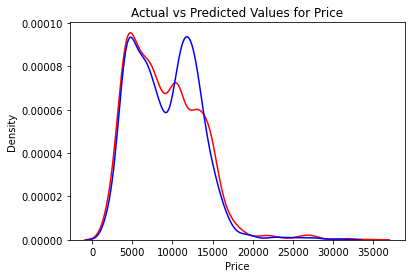

In [786]:
ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values" , ax=ax)

plt.title('Actual vs Predicted Values for Price')


plt.show()


In [787]:
def predict(ml_model):
    model= ml_model.fit(X_train,y_train)
    print("Training_Score: {}".format(model.score(X_train,y_train)))
    y_prediction=model.predict(X_test)
    print("Prdiction are: {}".format(y_prediction))
    print('\n')
    
    from sklearn import metrics
    r2_score=metrics.r2_score(y_test,y_prediction)
    print("r2 Scroe {}".format(r2_score))
    print("MSE : ", metrics.mean_squared_error(y_test,y_prediction))
    print("MAE : ", metrics.mean_absolute_error(y_test,y_prediction))
    print("RMSE : ",np.sqrt(metrics.mean_squared_error(y_test,y_prediction)))
    print("MASE : ",mape(y_test,y_prediction))
    
    sns.displot(y_test-y_prediction,aspect=3)

Training_Score: 0.9509059919644965
Prdiction are: [16739.41  6039.84  8875.73 ...  3523.89  6385.99  7370.9 ]


r2 Scroe 0.812299762359249
MSE :  3654073.0834962437
MAE :  1177.8521098727285
RMSE :  1911.5629949065878
MASE :  13.245300697429762


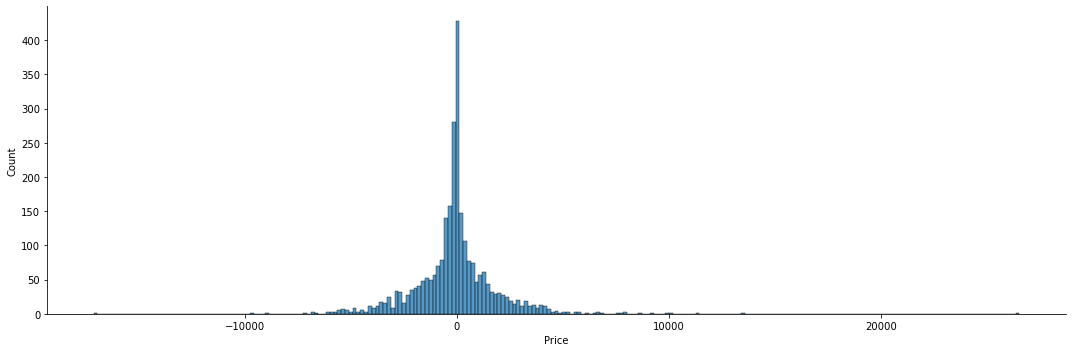

In [788]:
predict(RandomForestRegressor()) #observe peak desnsity at Price=0

In [789]:
predict_actual=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})

In [790]:
predict_actual

,Actual,Predicted
6075,16655.0,16739.410000
3544,4959.0,6158.040000
9291,9187.0,8893.220000
5032,3858.0,3774.820000
2483,12898.0,14949.951167
...,...,...
3022,13555.0,12785.844286
8416,12760.0,19185.572500
2605,3419.0,3617.580000
1392,5797.0,6344.370000


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



Text(0.5, 1.0, 'Actual values vs Predicted Values')

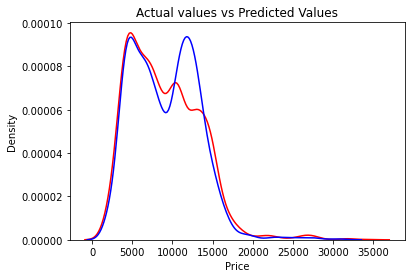

In [791]:
ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values" , ax=ax)

plt.title('Actual values vs Predicted Values')

In [792]:
#cross validation: need to tweek parameters to find optimal value 
from sklearn.model_selection import RandomizedSearchCV

In [793]:
reg_rf=RandomForestRegressor()

In [794]:
np.linspace(start=1000,stop=1200,num=6)

array([1000., 1040., 1080., 1120., 1160., 1200.])

In [795]:
n_estimators=[int(x) for x in np.linspace(start=1000,stop=3000,num=20)]

max_features =["auto","sqrt"]

min_samples_split=[5,10,25,100]

max_depth=[int(x) for x in np.linspace(start=5,stop=30,num=4)]

In [796]:
random_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'max_depth': max_depth    
}

In [797]:
random_reg=RandomizedSearchCV(reg_rf,param_distributions=random_grid,cv=5,verbose=2,n_jobs=-1)

In [798]:
random_reg.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 25, 100],
                                        'n_estimators': [1000, 1105, 1210, 1315,
                                                         1421, 1526, 1631, 1736,
                                                         1842, 1947, 2052, 2157,
                                                         2263, 2368, 2473, 2578,
                                                         2684, 2789, 2894,
                                                         3000]},
                   verbose=2)

In [526]:
random_reg.best_params_
pred2=random_reg.predict(X_test)#Value after hypertuning
from sklearn import metrics
metrics.r2_score(y_test,pred2)

0.8323337728895455

In [527]:
model=RandomForestRegressor()
model.fit(X_train,y_train)
pred1=model.predict(X_test)#Value before hypertuning
from sklearn import metrics
metrics.r2_score(y_test,pred1)

0.8099533270489331

In [401]:
dict={'Y_test':y_test,'Y_Pred':y_pred}
test=pd.DataFrame(dict)